# Projet DataMining
Auteur : Evan Tassel, Cyril Recordon  
Date : 2025-02-15  
Version : 1.3


## Initialisation

In [1]:
!pip3 install numpy pandas matplotlib sparqlwrapper

Defaulting to user installation because normal site-packages is not writeable


## Collecte de données  

### Obectifs

Vous devez collecter et télécharger un ensemble d'images. Vous avez les tâches suivantes à programmer, en automatisant le processus autant que possible :

1.  Créer un dossier appelé *images*.
2.  Télécharger les images sous licence ouverte dans le dossier *images* (minimum 100
    images).
3.  Enregistrez les métadonnées de chaque image comme la taille de l'image, le format de l'image (.jpeg,
    .png, etc.), l'orientation de l'image (paysage, portrait, carré, etc.),
    date de création, modèle d'appareil photo, etc. dans un ou plusieurs fichiers JSON. Vous pouvez utiliser les informations [Exif](https://en.wikipedia.org/wiki/Exif) présentes dans les fichiers d'images.

In [ ]:
## Imports

import numpy as np
import pandas as pd
import matplotlib as plot
import SPARQLWrapper as sw
import sys
import requests
import shutil
import os
from SPARQLWrapper import SPARQLWrapper, JSON
import json
from sklearn.cluster import KMeans
from PIL import Image
from PIL.ExifTags import TAGS
import ipywidgets as widgets
from IPython.display import display
from collections import Counter
import matplotlib.pyplot as plt


In [3]:
## Chargement des requetes

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT DISTINCT ?gratte_ciel ?gratte_cielLabel ?pays ?paysLabel ?image ?hauteur WHERE {
?gratte_ciel wdt:P31 wd:Q11303;  # Q11303 est l'identifiant pour "gratte-ciel"
            wdt:P17 ?pays;        # Pays
            wdt:P18 ?image;       # Image
            wdt:P2048 ?hauteur.  # Hauteur
SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
}
LIMIT 110"""

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

# Fonction pour télécharger les images
def download_image(url):
    print(f"Téléchargement de : {url}") 
    headers = {"User-Agent": "Mozilla/5.0"}
    filename = os.path.join("images", os.path.basename(url))
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code != 200:
        print(f"Erreur de téléchargement : {request.status_code} pour {url}")
    if request.status_code == 200:
        with open(filename, "wb") as image:
            image.write(request.content)
    return request.status_code
    

array = []
results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    if "image" in result :
        array.append(
            (
                result["gratte_cielLabel"]["value"],
                result["paysLabel"]["value"],
                result["image"]["value"],
                result["hauteur"]["value"]
            )
        )

dataframe = pd.DataFrame(array, columns=["gratte_cielLabel", "paysLabel", "image", "hauteur"])
dataframe = dataframe.astype(
    dtype={"gratte_cielLabel": "<U200", "paysLabel": "<U200", "image": "<U200", "hauteur": "float32"}
)
dataframe["image"]

0      http://commons.wikimedia.org/wiki/Special:File...
1      http://commons.wikimedia.org/wiki/Special:File...
2      http://commons.wikimedia.org/wiki/Special:File...
3      http://commons.wikimedia.org/wiki/Special:File...
4      http://commons.wikimedia.org/wiki/Special:File...
                             ...                        
105    http://commons.wikimedia.org/wiki/Special:File...
106    http://commons.wikimedia.org/wiki/Special:File...
107    http://commons.wikimedia.org/wiki/Special:File...
108    http://commons.wikimedia.org/wiki/Special:File...
109    http://commons.wikimedia.org/wiki/Special:File...
Name: image, Length: 110, dtype: object

In [4]:
## Téléchargement des requetes dans dataframe

for url in dataframe["image"]:
    download_image(url)

Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/PBC-2.jpg
Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/NewportTower.jpg
Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/Los%20Angeles%20-%20Bank%20America%20building%20from%20Historic%20LAPD%20Academy.JPG
Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/WSTM%20Mark%20Frank%200076.jpg
Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/Intraco%20I%20-%20radek%20ko%C5%82akowski.jpg
Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/Opernturm-Frankfurt-2010-Ffm-b.jpg
Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/Wenzhou%20World%20Trade%20Center%20dans%20son%20environnement%20urbain.JPG
Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/S%C3%BCddeutscher%20Verlag%2C%20M%C3%BCnchen%2C%20Hochhaus%2C%20Westen.jpg
Téléchargement de : http://commons.wikimedia.org/wiki/Spec

In [5]:
## Gestion des métadatas dans metadata.json

def convert_value(value):
    """Convertit les valeurs non sérialisables en JSON (IFDRational, bytes, etc.)."""
    if isinstance(value, bytes):
        return value.decode(errors="ignore")  # Convertir en texte
    elif isinstance(value, tuple):
        return tuple(convert_value(v) for v in value)  # Convertir chaque élément d'un tuple
    else:
        return str(value) 

def get_image_metadata(image_path):
    """Récupère les métadonnées d'une image."""
    metadata = {}
    
    try:
        with Image.open(image_path) as img:
            # Taille et format
            width, height = img.size
            metadata["filename"] = os.path.basename(image_path)
            metadata["size"] = f"{width}x{height}"
            metadata["format"] = img.format
            
            # Orientation
            if width > height:
                metadata["orientation"] = "Paysage"
            elif height > width:
                metadata["orientation"] = "Portrait"
            else:
                metadata["orientation"] = "Carré"
            
            # Extraction des métadonnées Exif
            exif_data = img._getexif()
            List_tag = ["filename", "size", "format", "orientation", "GPSInfo", "Make", "Model", "DateTime"]
            if exif_data:
                for tag_id, value in exif_data.items():
                    tag_name = TAGS.get(tag_id, tag_id)  # Convertir ID en nom lisible
                    if tag_name not in List_tag :
                        continue  # Ignorer tout sauf les tags sauf ceux dans List_tag
                    metadata[tag_name] = convert_value(value)
            

    except Exception as e:
        metadata["error"] = str(e)
    
    return metadata

def save_metadata_to_json(folder="images", output_file="metadata.json"):
    """Parcourt toutes les images du dossier et enregistre leurs métadonnées dans un JSON."""
    metadata_list = []
    
    for filename in os.listdir(folder):
        image_path = os.path.join(folder, filename)
        if os.path.isfile(image_path) and filename.lower().endswith(("jpg", "jpeg", "png")):
            metadata = get_image_metadata(image_path)
            metadata_list.append(metadata)
    
    with open(output_file, "w", encoding="utf-8") as json_file:
        json.dump(metadata_list, json_file, indent=4, ensure_ascii=False)
    
    print(f" Métadonnées enregistrées dans le fichier {output_file}")

save_metadata_to_json()

 Métadonnées enregistrées dans le fichier metadata.json


/home/evan/.local/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (117370000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


## Étiquetage et annotation  

### Objectifs

Pour cette tâche, vous devez rechercher les sources disposant d'informations supplémentaires comme les balises, les catégories, etc.

Dans cette tâche, vous devrez peut-être étiqueter, annoter et enregistrer des informations sur chaque image. Vous pouvez analyser les images en utilisant des algorithmes de regroupement pour trouver les couleurs prédominantes.

Vous disposez déjà de certaines métadonnées provenant de l'EXIF des images de la précédente tâche. Dans cette tâche, votre objectif est d'obtenir des informations supplémentaires, comme les couleurs prédominantes, les tags. Et si vous demandiez aux utilisateurs de tagger les images ? Par exemple, les noms de couleurs, #cat, #fleur, #sous-fleur, rose etc.

Comment prévoyez-vous de traiter ces tags ? Est-il possible d'automatiser ce processus ?

In [6]:
## Détection de couleurs principales 

JSON_FILE = "metadata.json"
IMAGE_FOLDER = "images"
N_CLUSTERS = 4  # Nombre fixe de couleurs principales (une méthode de détection automatique a été envisagé mais prend plus de temps)

def load_metadata():
    """Charge le fichier JSON existant ou retourne une liste vide."""
    return json.load(open(JSON_FILE, "r", encoding="utf-8")) if os.path.exists(JSON_FILE) else []

def save_metadata(metadata):
    """Sauvegarde les métadonnées mises à jour."""
    with open(JSON_FILE, "w", encoding="utf-8") as file:
        json.dump(metadata, file, indent=4, ensure_ascii=False)

def extract_colors(image_path):
    """Extrait les 4 couleurs principales d'une image."""
    img = Image.open(image_path).convert("RGB").resize((100, 100))
    pixels = np.array(img.getdata(), dtype=np.uint8)

    kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=5, random_state=42)
    labels = kmeans.fit_predict(pixels)
    histogram = np.bincount(labels)

    sorted_indices = np.argsort(histogram)[::-1]  # Tri décroissant
    return [
        {
            "rgb": tuple(map(int, kmeans.cluster_centers_[idx][:3])),
            "hex": "#%02x%02x%02x" % tuple(map(int, kmeans.cluster_centers_[idx][:3])),
            "percentage": round((histogram[idx] / len(labels)) * 100, 2),
        }
        for idx in sorted_indices
    ]

def update_metadata():
    """Ajoute les couleurs principales aux métadonnées des images."""
    metadata = {meta["filename"]: meta for meta in load_metadata()}

    count = 0
    for filename in os.listdir(IMAGE_FOLDER):
        if filename.lower().endswith(("jpg", "jpeg", "png")):
            count += 1
            image_path = os.path.join(IMAGE_FOLDER, filename)
            print(f"Analyse de {filename}...")
            metadata[filename]["colors"] = extract_colors(image_path)

    save_metadata(list(metadata.values()))
    print("Nombre d'images analysées en terme de couleurs : ",count)

update_metadata()

Analyse de Shin%20Marunouchi%20Bldg.jpg...
Analyse de CathoLearn.jpg...
Analyse de 15%20Park%20Row%203.JPG...
Analyse de Pirelli%20tower%20%2827559885391%29.jpg...
Analyse de %E4%B8%AD%E5%9B%BD%E4%B8%AD%E5%A4%AE%E7%94%B5%E8%A7%86%E5%8F%B02012.10.03China%20Central%20Television%20-%20panoramio.jpg...
Analyse de Wenzhou%20World%20Trade%20Center%20dans%20son%20environnement%20urbain.JPG...
Analyse de Opernturm-Frankfurt-2010-Ffm-b.jpg...
Analyse de 2Prud.jpg...
Analyse de New%20York%20-%20Manhattan%20-%20Plaza%20Hotel.jpg...
Analyse de WHITE%20SWAN%20HOTEL%20%282017-10-14%29.jpg...
Analyse de POL%20Warszawa%20Cosmopolitan%2001.jpg...
Analyse de Carlton%20Centre%202.jpg...
Analyse de Bank%20of%20America%20Miami%2020100206.jpg...
Analyse de 26%20Broadway%20004.JPG...
Analyse de 4timessquare%2023may2005.JPG...
Analyse de Dubai%20night%20skyline.jpg...
Analyse de Hypo-Haus.JPG...
Analyse de Marunouchi%20Building.JPG...
Analyse de Dub-emtow.jpg...
Analyse de Fisher%20Building%20Detroit%20crop.j

/home/evan/.local/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (117370000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Analyse de CWFC.JPG...
Analyse de Broadgate%20Tower.jpg...
Analyse de Frankfurt%20Taunusturm.20140417.jpg...
Analyse de Taipei.shinkong01.altonthompson.jpg...
Analyse de S%C3%BCddeutscher%20Verlag%2C%20M%C3%BCnchen%2C%20Hochhaus%2C%20Westen.jpg...
Analyse de NewportTower.jpg...
Nombre d'images analysées en terme de couleurs :  107


In [1]:
## Affichage des images et mise à jour des favoris et tags pour un utilisateur

# Fichiers
FAVORITES_FILE = "favorites.json"
IMAGE_FOLDER = "images"

# Charger les favoris existants ou créer un fichier vide
def load_favorites():
    if os.path.exists(FAVORITES_FILE):
        with open(FAVORITES_FILE, "r", encoding="utf-8") as file:
            return json.load(file)
    return {"favorites": []}

def save_favorites(data):
    with open(FAVORITES_FILE, "w", encoding="utf-8") as file:
        json.dump(data, file, indent=4, ensure_ascii=False)

# Demande le nom de l'utilisateur
user_name = input("Entrez votre nom d'utilisateur : ").strip()

# Charger les images du dossier
image_files = [f for f in os.listdir(IMAGE_FOLDER) if f.lower().endswith(("jpg", "jpeg", "png"))]

# Widgets pour sélectionner les favoris et ajouter des tags
checkboxes = [widgets.Checkbox(value=False, description="Favori") for _ in image_files]
tag_inputs = [widgets.Text(placeholder="Ajoutez des tags séparés par des virgules") for _ in image_files]

# Création de l'affichage
grid = widgets.VBox([])
for img_file, checkbox, tag_input in zip(image_files, checkboxes, tag_inputs):
    image_path = os.path.join(IMAGE_FOLDER, img_file)
    
    # Afficher l'image en taille correcte
    with Image.open(image_path) as img:
        img.thumbnail((150, 150))  # Ajuster la taille
        img_widget = widgets.Image(value=open(image_path, "rb").read(), format='png', width=150, height=150)
    
    grid.children += (widgets.HBox([img_widget, checkbox, tag_input]),)

# Bouton pour enregistrer les favoris
save_button = widgets.Button(description="Enregistrer les favoris")
output = widgets.Output()

# Fonction pour enregistrer la sélection
def save_selection(_):
    favorites_data = load_favorites()

    for img_file, checkbox, tag_input in zip(image_files, checkboxes, tag_inputs):
        if checkbox.value:  # Image cochée comme favorite
            tags = [tag.strip() for tag in tag_input.value.split(",") if tag.strip()]
            
            # Vérifier si l'image a déjà été mise en favoris avant
            existing_entry = next((fav for fav in favorites_data["favorites"] if fav["filename"] == img_file), None)

            if existing_entry:
                # Ajouter ou mettre à jour les tags pour cet utilisateur
                existing_entry["users"][user_name] = tags
            else:
                # Nouvelle entrée
                favorites_data["favorites"].append({
                    "filename": img_file,
                    "users": {user_name: tags}
                })

    # Sauvegarde dans le fichier JSON
    save_favorites(favorites_data)

    # Affichage du résultat
    with output:
        output.clear_output()
        print(f"Favoris enregistrés pour {user_name} !")

# Associer la fonction au bouton
save_button.on_click(save_selection)

# Affichage
display(grid, save_button, output)

### ATTENTION l'affichage peut prendre beaucoup de temps (environ 2 minutes pour 100 images dans mon cas) ###


KeyboardInterrupt: Interrupted by user

## Analyses de données

Demandez à l'utilisateur de sélectionner quelques images et d'ajouter des balises. Pour chaque utilisateur, vous êtes
maintenant prêt à construire un profil de préférences d'utilisateur, basé sur cette sélection.
Vous pouvez recueillir les informations suivantes manuellement, mais l'objectif de
cette tâche consiste à les obtenir en utilisant les images sélectionnées de manière automatisée : 

1.  Couleurs préférées
2.  Orientation de l'image préférée
3.  Tailles d'images préférées (vignettes, grandes images, images de taille moyenne
    images, etc.)
4.  Balises favorites

Maintenant, grâce à votre connaissance des différents types de classificateurs et
les algorithmes de regroupement, quelles informations supplémentaires ajouterez-vous pour chaque
image ?

Votre prochain objectif est d'analyser les informations des utilisateurs et leurs images préférées. Comment avez-vous créé des utilisateurs aléatoires ? Combien d'utilisateurs avez-vous
créer ? Quelles informations avez-vous stockées pour chaque utilisateur ? Quels types d'analyses avez-vous effectuées ?

## Visualisation des données

Dans cette tâche, votre objectif est de visualiser les différentes caractéristiques de
toutes les images téléchargées.

1.  Le nombre d'images disponibles pour chaque année
2.  Le nombre d'images disponibles pour les différents types : taille de l'image,
    l'orientation des images, les modèles d'appareils photo, etc. 
3.  Caractéristiques des couleurs

Les utilisateurs peuvent également visualiser les informations ci-dessus relatives à leurs images préférées. Dans cette tâche, vous devez également ajouter une fonctionnalité permettant aux utilisateurs de visualiser les informations liées à leur propre profil d'utilisateur.

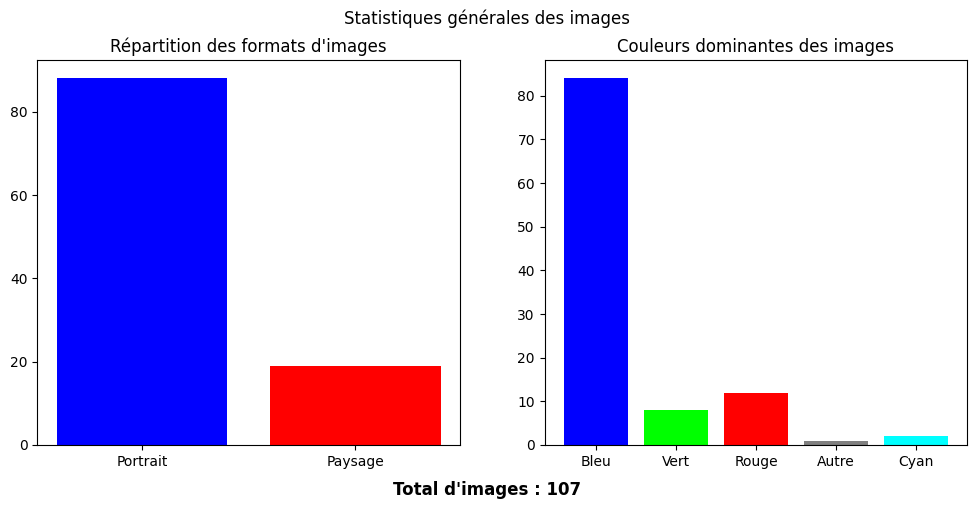

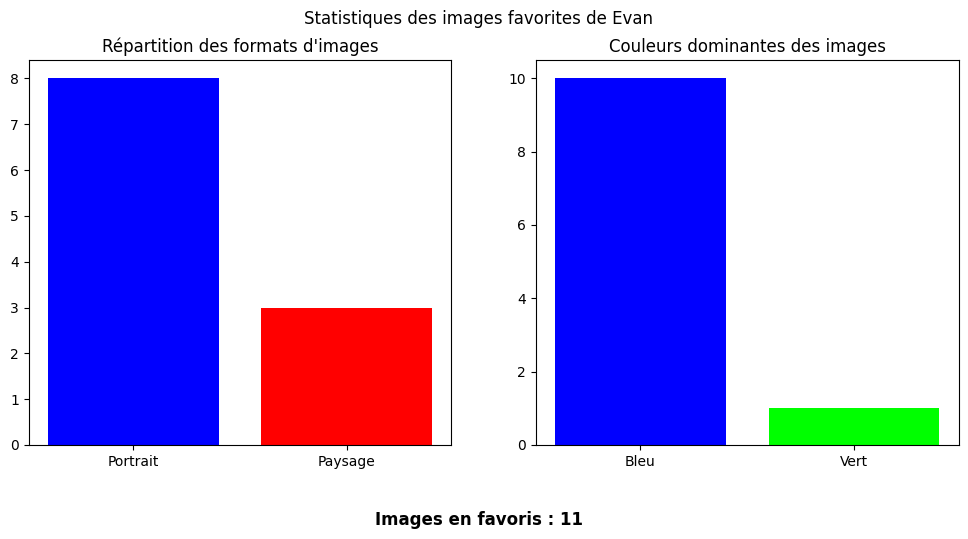


Tags les plus utilisés par Evan :
Tag                  | Occurrences
----------------------------------------
castle               | 3         
cubique              | 2         
old                  | 1         
bridge               | 1         
night                | 1         
big                  | 1         


In [10]:
## Analyse et visualisation des données

# Fichiers
METADATA_FILE = "metadata.json"
FAVORITES_FILE = "favorites.json"

# Charger les métadonnées des images
def load_metadata():
    if os.path.exists(METADATA_FILE):
        with open(METADATA_FILE, "r", encoding="utf-8") as file:
            return json.load(file)
    return []

# Charger les favoris
def load_favorites():
    if os.path.exists(FAVORITES_FILE):
        with open(FAVORITES_FILE, "r", encoding="utf-8") as file:
            return json.load(file)
    return {"favorites": []}

# Fonction pour regrouper les couleurs principales
def categorize_color(rgb):
    """Associe une couleur RGB à une grande catégorie"""
    r, g, b = rgb
    if r > g and r > b:
        return "Rouge", "#FF0000"
    elif g > r and g > b:
        return "Vert", "#00FF00"
    elif b > r and b > g:
        return "Bleu", "#0000FF"
    elif abs(r - g) < 30 and r > b:
        return "Jaune", "#FFFF00"
    elif abs(r - g) < 30 and b > r:
        return "Cyan", "#00FFFF"
    elif abs(r - b) < 30 and g > r:
        return "Vert clair", "#90EE90"
    else:
        return "Autre", "#808080"

# Analyser les métadonnées
def analyze_images():
    metadata = load_metadata()

    format_counter = Counter()
    color_counter = Counter()
    color_map = {}

    for data in metadata:
        format_counter[data["orientation"]] += 1

        if "colors" in data:
            dominant_color = data["colors"][0]["rgb"]
            category, hex_color = categorize_color(dominant_color)
            color_counter[category] += 1
            color_map[category] = hex_color  # Associer la catégorie à sa couleur

    return format_counter, color_counter, color_map, len(metadata)  # Ajout du nombre total d'images

# Générer les stats par utilisateur
def analyze_all_users():
    metadata = {meta["filename"]: meta for meta in load_metadata()}
    favorites = load_favorites()["favorites"]

    user_stats = {}

    for fav in favorites:
        for user, tags in fav["users"].items():
            if user not in user_stats:
                user_stats[user] = {
                    "format_counter": Counter(),
                    "color_counter": Counter(),
                    "color_map": {},
                    "tag_counter": Counter(),  # Ajout des tags
                    "image_count": 0  # Compteur d'images favorites
                }

            filename = fav["filename"]
            if filename in metadata:
                user_stats[user]["format_counter"][metadata[filename]["orientation"]] += 1
                user_stats[user]["image_count"] += 1  # Incrémenter le compteur d'images favorites

                if "colors" in metadata[filename]:
                    dominant_color = metadata[filename]["colors"][0]["rgb"]
                    category, hex_color = categorize_color(dominant_color)
                    user_stats[user]["color_counter"][category] += 1
                    user_stats[user]["color_map"][category] = hex_color

            # Ajouter les tags
            if tags:
                user_stats[user]["tag_counter"].update(tags)

    return user_stats

# Affichage des stats avec matplotlib
def plot_stats(format_counter, color_counter, color_map, title, total_images=None, fav_images=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Graphique des orientations
    axes[0].bar(format_counter.keys(), format_counter.values(), color=["blue", "red", "green"])
    axes[0].set_title("Répartition des formats d'images")

    # Graphique des couleurs dominantes
    colors = list(color_counter.keys())
    values = list(color_counter.values())
    hex_colors = [color_map[color] for color in colors]  # Associer chaque barre à sa couleur

    axes[1].bar(colors, values, color=hex_colors)
    axes[1].set_title("Couleurs dominantes des images")

    # Ajouter un texte avec le nombre total d'images
    if total_images is not None:
        fig.text(0.5, 0.01, f"Total d'images : {total_images}", ha='center', fontsize=12, fontweight='bold')

    if fav_images is not None:
        fig.text(0.5, -0.05, f"Images en favoris : {fav_images}", ha='center', fontsize=12, fontweight='bold')

    plt.suptitle(title)
    plt.show()

# Affichage des tags préférés sous forme de tableau
def display_tags(tags_counter, user):
    print(f"\nTags les plus utilisés par {user} :")
    print("=" * 40)
    print("{:<20} | {:<10}".format("Tag", "Occurrences"))
    print("-" * 40)

    for tag, count in tags_counter.most_common(10):  # Afficher les 10 tags les plus fréquents
        print("{:<20} | {:<10}".format(tag, count))
    print("=" * 40)

# Exécuter les stats générales
format_stats, color_stats, color_map, total_images = analyze_images()
plot_stats(format_stats, color_stats, color_map, "Statistiques générales des images", total_images=total_images)

# Exécuter les stats pour tous les utilisateurs
user_stats = analyze_all_users()
for user, stats in user_stats.items():
    plot_stats(stats["format_counter"], stats["color_counter"], stats["color_map"], 
               f"Statistiques des images favorites de {user}", fav_images=stats["image_count"])
    
    # Afficher les tags préférés
    display_tags(stats["tag_counter"], user)


## Système de recommandation

Êtes-vous maintenant prêt à recommander des images à un utilisateur ? Dans cette tâche, votre objectif est de construire le système de recommandation. Quelle approche avez-vous décidé de prendre ? Filtrage collaboratif, basé sur le contenu ou une approche hybride ? Quel(s) algorithme(s) avez-vous choisi (classification, clustering, ...) ? Pour chaque utilisateur, êtes-vous maintenant en mesure de construire une profil ? Quel type d'information avez-vous utilisé pour établir un profil d'utilisateur profil ? Qu'est-ce qui manque ? Quelles sont les limites de votre proposition ?

In [9]:
## Systeme de recommandations

# Fichiers 
FAVORITES_FILE = "favorites.json"
METADATA_FILE = "metadata.json"
IMAGE_FOLDER = "images"

# Charger les favoris
def load_favorites():
    if os.path.exists(FAVORITES_FILE):
        with open(FAVORITES_FILE, "r", encoding="utf-8") as file:
            return json.load(file)
    return {"favorites": []}

# Charger les métadonnées des images
def load_metadata():
    if os.path.exists(METADATA_FILE):
        with open(METADATA_FILE, "r", encoding="utf-8") as file:
            return json.load(file)
    return []

# Sauvegarder les favoris
def save_favorites(data):
    with open(FAVORITES_FILE, "w", encoding="utf-8") as file:
        json.dump(data, file, indent=4, ensure_ascii=False)

# Fonction pour obtenir les couleurs dominantes d'une image
def get_dominant_colors(image_data):
    return [color["hex"] for color in image_data.get("colors", [])]

# Trouver des images similaires (basé sur couleurs, tags, orientation et taille)
def find_similar_images(user_name, metadata, favorites_data, min_match=1):
    user_favorites = [fav for fav in favorites_data["favorites"] if user_name in fav["users"]]
    favorite_images = {fav["filename"] for fav in user_favorites}

    favorite_colors = Counter()
    favorite_tags = Counter()
    favorite_orientations = Counter()
    favorite_sizes = []

    for fav in user_favorites:
        for img in metadata:
            if img["filename"] == fav["filename"]:
                favorite_colors.update(get_dominant_colors(img))
                favorite_tags.update(fav["users"].get(user_name, []))
                favorite_orientations[img["orientation"]] += 1
                
                # Convertir la taille en valeurs numériques
                width, height = map(int, img["size"].split("x"))
                favorite_sizes.append((width, height))

    recommended = []

    for img in metadata:
        if img["filename"] in favorite_images:
            continue  # Ne pas recommander une image déjà en favoris
        
        img_colors = set(get_dominant_colors(img))
        img_tags = set()
        
        for fav in favorites_data["favorites"]:
            if fav["filename"] == img["filename"]:
                img_tags.update(fav["users"].get(user_name, []))
        
        width, height = map(int, img["size"].split("x"))
        img_orientation = img["orientation"]

        # Vérifier la similarité avec les favoris
        color_matches = len(img_colors & favorite_colors.keys())
        tag_matches = len(img_tags & favorite_tags.keys())
        orientation_match = favorite_orientations.get(img_orientation, 0) > 0
        size_match = any(abs(width - w) / w < 0.1 and abs(height - h) / h < 0.1 for w, h in favorite_sizes)

        # Calcul du score global
        score = color_matches + tag_matches
        if orientation_match:
            score += 2  # Bonus si l'orientation correspond
        if size_match:
            score += 2  # Bonus si la taille est similaire

        if score >= min_match:
            recommended.append((img["filename"], score))
    
    recommended.sort(key=lambda x: x[1], reverse=True)
    return [img[0] for img in recommended[:5]]  # Limité à 5 recommandations


# Demander le nom de l'utilisateur
user_name = input("Entrez votre nom d'utilisateur : ").strip()

# Charger les données
metadata = load_metadata()
favorites_data = load_favorites()

# Trouver les recommandations
recommended_images = find_similar_images(user_name, metadata, favorites_data)

# Widgets pour afficher les recommandations et permettre d'ajouter aux favoris avec tags
if recommended_images:
    print("Images recommandées :")
    checkboxes = []
    tag_inputs = []
    grid = widgets.VBox([])

    for img_file in recommended_images:
        image_path = os.path.join(IMAGE_FOLDER, img_file)
        checkbox = widgets.Checkbox(value=False, description="Ajouter aux favoris")
        tag_input = widgets.Text(placeholder="Ajoutez des tags (séparés par des virgules)")

        checkboxes.append((img_file, checkbox, tag_input))
        tag_inputs.append(tag_input)

        # Afficher l'image
        with Image.open(image_path) as img:
            img.thumbnail((150, 150))
            img_widget = widgets.Image(value=open(image_path, "rb").read(), format='png', width=150, height=150)

        grid.children += (widgets.HBox([img_widget, checkbox, tag_input]),)

    # Bouton pour enregistrer les nouveaux favoris avec tags
    save_button = widgets.Button(description="Enregistrer les nouveaux favoris")
    output = widgets.Output()

    def save_new_favorites(_):
        for img_file, checkbox, tag_input in checkboxes:
            if checkbox.value:
                tags = [tag.strip() for tag in tag_input.value.split(",") if tag.strip()]
                existing_entry = next((fav for fav in favorites_data["favorites"] if fav["filename"] == img_file), None)
                
                if existing_entry:
                    existing_entry["users"].setdefault(user_name, []).extend(tags)
                else:
                    favorites_data["favorites"].append({"filename": img_file, "users": {user_name: tags}})

        save_favorites(favorites_data)
        with output:
            output.clear_output()
            print("Favoris mis à jour avec les tags !")

    save_button.on_click(save_new_favorites)
    display(grid, save_button, output)
else:
    print("Aucune recommandation disponible pour le moment. Essayez d'ajouter plus de favoris pour affiner les suggestions.")



Aucune recommandation disponible pour le moment. Essayez d'ajouter plus de favoris pour affiner les suggestions.


## Tests

Votre prochaine tâche consiste à mettre au point et à effectuer différents tests sur votre proposition système. Les différentes fonctions sont-elles fonctionnelles ? Comment avez-vous testé votre projet ? Comment vérifiez-vous que votre système de recommandation fonctionne ?